<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 5


## Important notes

**Submission deadline:**
**lab session of the week 7.11-11.11 2022**

**Points: 1+3=4**

Please let us know about any problems with it -- we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

# Statistical Learning

In this homework we will be reinforcing our understanding of the probabilistic approach to the machine learning.



Suppose we are given a task of getting to know how many people in Poland prefer coffee over tea.
Imagine yourself that you can ask absolutely every person in Poland whether they prefer coffee over tea. If we would count the number $n_{c}$ of the people who said "coffee > tea", then our task would be done.
However, this is just practically impossible.

Still, we can do something to get a reasonable estimation of this number.
And the idea for this is as follows.

Poland has around 38,179,800 citizens as of 2021. Now look at the ratio $\frac{n_{c}}{38,179,800}$. Imagine yourself another situation --- which now seems a bit more reasonable than asking every person in Poland about coffee --- where you can take a random person in Poland and ask them about whether they are coffee>tea. The answer will be yes/no, or in our numeric language 0/1. However, the probability of getting `yes` will be exactly $\frac{n_{c}}{38,179,800}$.
In this notebook we will be looking at how to estimate this probability properly.

But already at this moment let it sink in what is going to happen.
The number $n_c$ is just there, it's fixed. But we cannot get to know its exact value directly. Hence we are going to *learn* it, and we are going to learn it using a randomized approach.


### A polling simulator
Let's simulate the polling process. We will generate IID random binary values, then count the fraction of observed 1's. In our case 1 is a "coffee>tea" person.



Let $\phi = \frac{n_{c}}{38,179,800}$ be the ratio of the true number of coffee enjoyers over the whole population. Again, we cannot get the true value of $\phi$, but we are going to learn it via estimates we gonna denote by $\bar{\phi}$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

In [ ]:
phi = 0.55  # True ratio of coffee>tea population
n = 50  # The sample size
n_sims = 10 # number of simulations

# Simulate a few random draws
sample_means = np.ndarray(n_sims)
for i in range(n_sims):
    sample = np.random.rand(n) < phi  # rand gives us numbers between 0 and 1
    sample_means[i] = sample.sum()/n
    print (f"Asked {n} people about coffee vs tea. Observed {sample.sum()} average coffee enjoyers. "
           f"Empirical mean {1.0*sample.sum()/n:.3f} (model mean: {phi})")

print (f"\nMean of means: ", sample_means.mean())

Asked 50 people about coffee vs tea. Observed 23 average coffee enjoyers. Empirical mean 0.460 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 28 average coffee enjoyers. Empirical mean 0.560 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 24 average coffee enjoyers. Empirical mean 0.480 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 30 average coffee enjoyers. Empirical mean 0.600 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 27 average coffee enjoyers. Empirical mean 0.540 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 26 average coffee enjoyers. Empirical mean 0.520 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 29 average coffee enjoyers. Empirical mean 0.580 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 24 average coffee enjoyers. Empirical mean 0.480 (model mean: 0.55)
Asked 50 people about coffee vs tea. Observed 24 average coffee enjoyers. Empirical mean

Not surprisingly, every simulated "poll" returns slightly different results. Our sample size, 50, is quite small, and the observed means typically take values between 0.4 and 0.7. However please note, that while unlikely, the poll could return all zeros, or all ones!

Our first observation is thus: the result of a poll, that is the sample statistic $\bar\phi$ is a Random Variable as well. As such, it will have its very own probability distribution!

### The distribution of $\bar\phi$

Recall that $\bar\phi$ is the fraction of successes (heads, ones, coffee enjoyers) observed in $n$ independent trials.

The number of successes $k$ in $n$ Bernulli trials follows the [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution):
$$
p\left(k\text{ successes in }n\text{ trials}; n, \phi\right)=\binom{n}{k}\phi^k(1-\phi)^{n-k}.
$$

Where: $k$ is the number of successes, $n$ is the number of trials and $\phi$ is the probability of a success in a single trial.

Since $\bar\phi = k/n$ and $k$ is a discrete RV, we observe that
$$
p\left(\bar\phi = \frac{k}{n}; n, \phi\right) = p\left(k\text{ successes in }n\text{ trials}; n, \phi\right)
$$

Let's verify that this is the case using an experiment!

In [ ]:
N = 100000  # the number of polls to simulate
n = 100  # the number of trials in a single poll
phi = 0.55  # the probability of success of a single trial

poll_results = np.random.rand(N, n) < phi
k = poll_results.sum(1)  # fraction of successes in each poll

# choose bins such that each observation falls into the middle of some bin
bins = np.arange(-0.5, n+1, 1, dtype='float32')
plt.hist(k, bins=bins, density=True, alpha=0.3)

# now plot the binomial distribution
model = scipy.stats.binom(n=n, p=phi)
possible_successes = np.arange(n + 1)
# plot the PMF - probability mass function
plt.stem(possible_successes , model.pmf(possible_successes), 'b', 
         label='Binomial PMF', use_line_collection=True)
plt.axvline(phi * n, 0, 1, color='r', label=r'$n\phi$: expected sucess count')
plt.legend()
_ = plt.xlabel('success count k')

NameError: ignored

The plot shows us a histogram of many simuleted poll results. It exactly matches the Binomial distribution. We have also indicated the expected value of the number of sucesses, which equals $n\phi$.

### Statistical Inference: model parameter estimation

In Statistics and Machine Learning we only have access to the sample, in our case to one poll result. The goal is to learn something useful about the unknown population. Here we are interested in the true fraction $\phi$.

To perform this inference we will perform a Maximum Likelihood reasoning:
1. Suppose there is a population with true (*unknown*) fraction $\phi$.
2. We have observed a sample from this population with some *known* sample fraction $\bar\phi$.
3. Our observation has probablity $p(\bar\phi; \phi)$ of happening. We know the formula for this probability, but we don't know $\phi$.
4. However we can ask:
   What $\hat\phi$ would make our observed data sample the most probable?
   Formally, we search for a $\hat\phi$ which maximizes our chances of observing the data we have:
   $$
    \hat\phi = \underset{\Phi}{\operatorname{argmax}}p(\bar\phi; \Phi)
   $$

We will call $\mathcal{L}(\Phi) = p(\bar\phi; \Phi)$ the _likelihood_ of $\Phi$ and we will call its maximizer $\hat\phi$ the maximum likelihood estimator of the population's unknown $\phi$.

There are many $phi$'s above and it sure gets confusing. Let me restate how they are different:
- $\phi$ is a parameter of the true population, we don't know it
- $\bar\phi$ is a statistic computed on our data sample, we know it
- $\Phi$ is any possible value of $\phi$; in our case $\Phi$ is any possible value from $[0,1]$
- $\hat\phi$ is the maximizer of the data likelihood - is the parameter of a hypothetical population which makes the observed data the most likely.

Thus our reasoning assumes that we will estimate (or infer) the true, unknown $\phi$ with a $\hat\phi$ which makes what we have witnessed the most probable.

### Maximum Likelihood Estimation (MLE)

What is left for us is to find $\hat\phi$ or the MLE of $\phi$.

This amounts to finding the maximum of the likelihood, a process we may also call **learning**. We will again resort to calculus: apply the $\log$ to likelihood to make it easier to work with (a monotonic transformation doesn't change the location of the maximum), compute its derivative and find its zero crossing. Afterwards, we should check if the singular point found is a maximum by looking at the second derivative, we leave this as an exercise for the diligent reader.

$$\begin{split}
\hat\phi &= \underset{\Phi}{\operatorname{argmax}}\mathcal{L}(\Phi)  \\
&= \underset{\Phi}{\operatorname{argmax}}\log\mathcal{L}(\Phi)  \\
&= \underset{\Phi}{\operatorname{argmax}}\log p(\bar\phi = \frac{k}{n}; n, \Phi) \\
&= \underset{\Phi}{\operatorname{argmax}}\log \left[\binom{n}{k}\Phi^k(1-\Phi)^{n-k}\right] \\
&= \underset{\Phi}{\operatorname{argmax}}\log \left[\binom{n}{n\bar\phi}\Phi^{n\bar\phi}(1-\Phi)^{n-n\bar\phi}\right] \\
&= \underset{\Phi}{\operatorname{argmax}}\log \binom{n}{n\bar\phi} + n\bar\phi\log\Phi + (n-n\bar\phi)\log(1-\Phi)
\end{split}$$

We now compute the derivative with respect to $\Phi$. Notice that the first term disappears, because it does not depend on $\Phi$:

$$\begin{split}
\frac{\partial}{\partial\Phi}\log\mathcal{L}(\Phi) &= \frac{\partial}{\partial\Phi}\left[\log \binom{n}{n\bar\phi} + n\bar\phi\log\Phi + (n-n\bar\phi)\log(1-\Phi)\right] \\ 
&=\frac{n\bar\phi}{\Phi} - \frac{n-n\bar\phi}{1-\Phi}
\end{split}$$

Setting the derivative to zero we obtain:

$$\begin{split}
\frac{n\bar\phi}{\Phi} - \frac{n-n\bar\phi}{1-\Phi} &= 0 \\
\frac{n\bar\phi}{\Phi} &= \frac{n-n\bar\phi}{1-\Phi} \\
n\bar\phi(1-\Phi) &= (n-n\bar\phi)\Phi \\
\bar\phi -\bar\phi\Phi &= \Phi - \bar\phi\Phi \\
\bar\phi &= \Phi
\end{split}$$

Therefore the MLE estimator $\hat\phi$ is simply the sample mean $\bar\phi$: 
$$
\hat\phi = \underset{\Phi}{\operatorname{argmax}}\mathcal{L}(\Phi) = \bar\phi
$$

The result may seem too intuitive to be significant: the sample mean can be used to guess the population mean from which it was sampled. However, the MLE derivation has shown us a general principle that we can use to estimate the unknonw parameters of models which generate our data! 

## Back to polls --- the quality of the MLE estimator.

We have shown that the MLE (Maximum Likelihood Estimator) for $\phi$ is just the sample mean $\bar\phi$. However, how good it is? Recall, that $\bar\phi$ is a random variable itself. Its mean is $\phi$, which is good --- the poll result, on the average, will be close to the population's parameter. 

Hovewer, we may want to control how close it is for the majority of polls we may conduct.

In the following section we will derive the 95% confidence intervals for the estimator of $\phi$. In other words, we will derive an interval around $\bar\phi$, such that in 95% of the polls we conduct the true $\phi$ will be inside this interval.




### Bootstrap estimation of confidence interval

We will first use bootstrap to estimate the quality of the MLE estimator. We will then derive an analytical formula for the bounds.

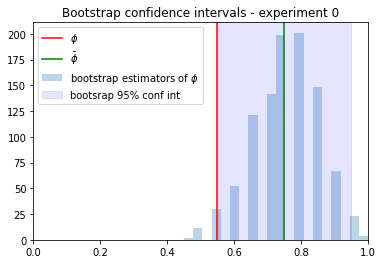

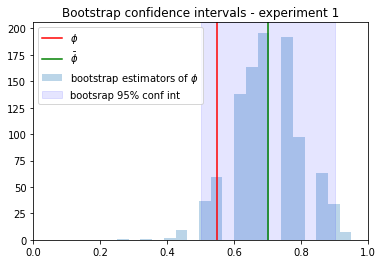

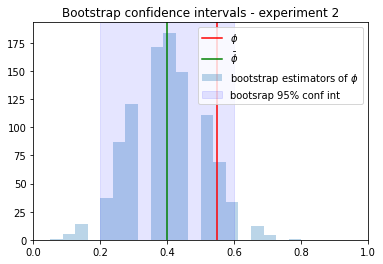

In [ ]:
np.random.seed(1)
phi = 0.55  # The model parameter: true probability p(1)
n = 20  # The sample size

def bootstrap_experiment(n, phi):
    data = np.random.rand(n) < phi  # A single poll
    bar_phi = data.mean()  # the MLE estimator of phi in this single experiment

    n_bootstrap_rounds = 1000

    # sample answers with replacement
    bootstrap_idx = np.random.randint(low=0, high=n, size=(n_bootstrap_rounds, n))
    bootstrap_datasets = data[bootstrap_idx]
    
    bootstrap_phis = bootstrap_datasets.mean(1)

    # Estimate the confidence interval by taking the 2.5 and 97.5 percentiles
    sorted_bootstrap_phis = np.sort(bootstrap_phis)
    bootstrap_conf_low, bootstrap_conf_high = sorted_bootstrap_phis[
        [int(0.025 * n_bootstrap_rounds), int(0.975 * n_bootstrap_rounds)]]

    plt.figure()
    # plot the true, unknown parameter
    plt.axvline(phi, 0, 1, label=r'$\phi$', color='red')
    # plot the MLE
    plt.axvline(bar_phi, 0, 1, label=r'$\bar\phi$', color='green')
    # Plot the bootstrap estimates
    plt.hist(sorted_bootstrap_phis, bins=20, alpha=0.3, label=r'bootstrap estimators of $\phi$')
    # Plot the bootstrap 95% confidence interval
    plt.axvspan(bootstrap_conf_low, bootstrap_conf_high,
                alpha=0.1, label='bootsrap 95% conf int', color='blue')
    plt.legend()
    _ = plt.xlim(0, 1)

for exp_id in range(3):
    bootstrap_experiment(n, phi)
    plt.title(f'Bootstrap confidence intervals - experiment {exp_id}')

In the experiments we have used a low poll size, to make the results more extreme. Please note that the estimates we are getting vary a lot. However, the true value of $\phi$ seems to always fall within the predicted bounds. If repeated enough times, **it should do so in 95% of experiments.** And let's verify also this.


### Problem 1[1p]

Perform the bootstrap experiment above 1000 times and verify that indeed around 95% of times the actual $\phi$ was in the confidence interval

In [ ]:
bound = 0
for exp_id in range(1000):
  if(bootstrap_experiment(n,phi)):
    bound +=1
result = bound/1000
print(result)

### the required sample size
Let's appreciate for a moment the bootstrap results. We have a simple model, from which we are drawing samples. The results of our draw are quite varied and a priori we don't know how good is our estimation. However, we can apply a simple computational procedure which shows us the amount of variability in our results. We can aggregate it to fomulate a 95% confidence bounds: an interval in which the true parameter is in 95% of the experiments.

We could now try to design an experiment: find a sample size that would give us a desired width of the confidence interval, by trying several sizes and estimating the bootstrap confidence intervals. In the following demonstration observe how the confidence interval narrows with increased sample sizes.

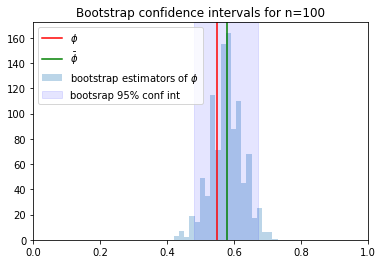

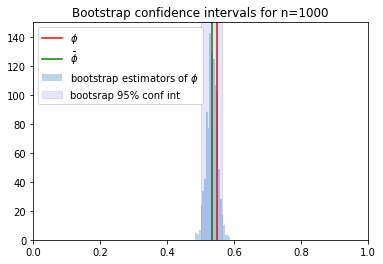

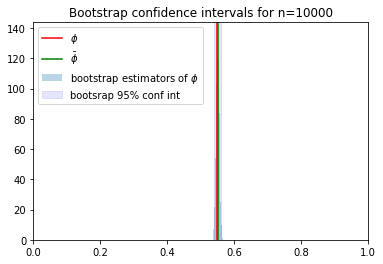

In [ ]:
phi = 0.55

for n in [100, 1000, 10000]:
    bootstrap_experiment(n, phi)
    plt.title(f'Bootstrap confidence intervals for n={n}')

The fact that more samples give better estimations come from the Law of Big Numbers, which in our case states that with probability one the limit of $\bar\phi$ as $n$ goes to infinity is actually the $\phi$ itself.

0.565

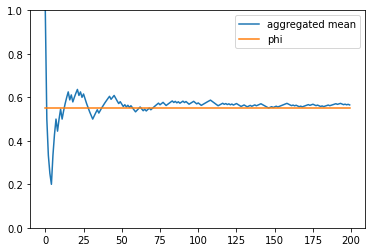

In [ ]:
import pandas as pd
n = 200
d = pd.DataFrame(index=np.arange(n))
d["vote for A"] = np.random.rand(n) < phi
d["aggregated mean"] = d["vote for A"].expanding().mean()
d["phi"] = phi
d.plot(ylim=(0.,1.))
d["aggregated mean"].iloc[-1]

Even though the Law of Big numbers doesn't give us the speed of convergence, often we do have also bounds on the speed. Many times such methods follow by relating the distribution to a normal one, and below we shall see how such a relation can be used.

However, a very natural question is how big `n` should we take to have confidence intervals small enough, so that we can quite surely say that our error of estimation is, let's say, 1%.

We can try to again estimate this number (this time number `n` of samples), but that would give us another layer of estimation on top of estimation. Luckily we can this time use some math instead of experiments.

### Derivation of confidence intervals

We want the (sample dependent) confidence interval around the sample mean, such that in 95% of experiments (conducted polls), the true unknown population parameter $\phi$ is within the confidence interval.

Formally we want to find $\bar\phi$ and $\epsilon$ such that $p(\bar\phi-\epsilon \leq \phi \leq \bar\phi + \epsilon) > 0.95$ or, equivalently, such that $p(|\phi-\bar\phi| \leq \epsilon) > 0.95$.

To estimate this interval please recall that $\bar\phi$ is the fraction of successes and that $k=n\bar\phi$, the success count follows a binomial distribution.

$$
p\left(\bar\phi = \frac{k}{n}; n, \phi\right) = p\left(k\text{ successes in }n\text{ trials}; n, \phi\right)=\binom{n}{k}\phi^k(1-\phi)^{n-k}.
$$

The excpected number of successes $k$ is $n\phi$, because expectation is linear and we are summing $n$ Bernulli variables. Thus the expectation of $\bar\phi$ is 

$$
\mathbb{E}[\bar\phi] = \mathbb{E}\left[\frac{k}{n}\right] = \frac{n\phi}{n} = \phi.
$$

The variance of the number of successes $k$ is $n\phi(1-\phi)$ because it is the variance of the sum of $n$ _independent_ Bernoulli variables and variance is additice for independent variables. It follows that

$$
\text{var}[\bar\phi] = \frac{\text{var}[k]}{n^2} = \frac{n\phi(1-\phi)}{n^2} = \frac{\phi(1-\phi)}{n}.
$$

We see that as the sample size $n$ grows, variance of the sample mean is reduced.

For a large enough sample size, we can approximate the binomial distribution with a normal one with a matched mean and variance. 


The fact that you can approximate binomial distribution with a normal one is phrased in the de Moivre-Laplace Theorem (https://en.wikipedia.org/wiki/De_Moivre%E2%80%93Laplace_theorem).
More formally it states that $\frac{\bar{\phi} - \phi}{\sqrt{n\cdot \phi(1-\phi)}}$ has distribution approximately close to $N(0,1)$, whatever the closeness between distributions is for now.

We will not go into details of this fact in this assignment list. But we gonna convince ourselves that it's in fact true.

# Problem 2 [3p]

Generate $k=88, 888, 8888, 88888$ samples from $\frac{\bar{\phi} - \phi}{\sqrt{n\cdot \phi(1-\phi)}}$ for $n=10,100,1000,10000$. Plot their histograms (separate for each $n$) together with a plot of $N(0,1)$. Perform statistical tests for normality of these distributions, one Kolmogorov-Smirnoff and one `scipy.stats.normaltest`. Print out the $p$-values.
Discuss why 1) the plots ain't terribly matching for `n=10`, 2) why the bigger the $k$ the harder it is to pass the KS test.

In [ ]:
import math 
from scipy.stats import normaltest
from scipy.stats import kstest
import seaborn as sns 

def do_stuff(k, n, phi):
  poll_results = np.random.rand(N, n) < phi
  k = poll_results.sum(1)
  data = np.exp(k/n - phi/(math.sqrt(n*phi*(1-phi))))
  print('data:',data)
  print(normaltest(data))
  plt.figure()
  plt.hist(data, bins='auto')
  plt.show()


data: [1.28453534 1.05168859 1.05168859 ... 0.86104979 1.05168859 1.4196311 ]
NormaltestResult(statistic=1992.315008291918, pvalue=0.0)


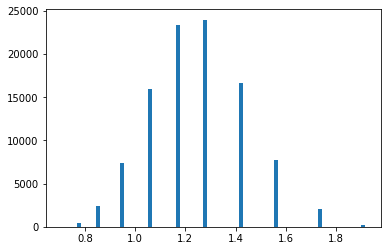

In [ ]:
do_stuff(k=88, n=10, phi=0.55)


data: [1.05168859 1.16229564 0.95160719 ... 1.28453534 0.95160719 1.56893501]
NormaltestResult(statistic=2023.096213405303, pvalue=0.0)


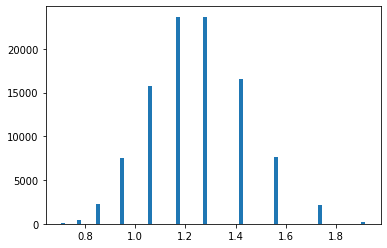

In [ ]:
do_stuff(k=8888, n=10,phi=0.55)

data: [0.99992965 0.99998392 1.00007237 ... 1.00012865 0.9998372  0.99999598]
NormaltestResult(statistic=1.6237985056711146, pvalue=0.44401397010894816)


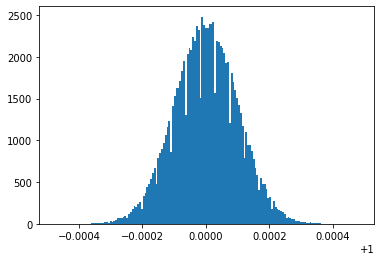

In [ ]:
do_stuff(k=88, n=10000,phi=0.55)

data: [1.71111394 1.70189883 1.73142468 ... 1.704965   1.69883816 1.71711333]
NormaltestResult(statistic=1.8014470584185185, pvalue=0.40627560110901106)


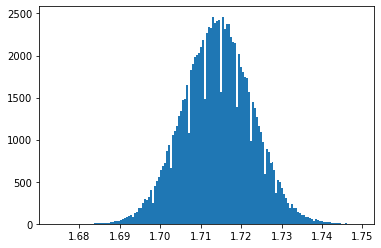

In [ ]:
do_stuff(k=8888, n=10000,phi=0.55)

NormaltestResult(statistic=0.8747667785938613, pvalue=0.6457238203464475)


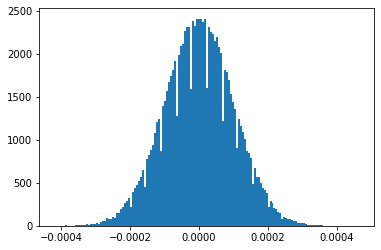

In [ ]:
do_stuff(k=88888, n=10000,phi=0.55)